In [1]:
import umap
import pandas as pd
import torch
from models.encoder import AutoEncoderCnn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from models.kl import compute_kl_divergence
import ndtest
from sklearn.decomposition import PCA


c:\Users\MarvinLob\anaconda3\envs\ml4h\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## The encodings can be downloaded from:
https://polybox.ethz.ch/index.php/s/X3E9vSZ0gTpL6ET

In [2]:
# load encoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoEncoderCnn()
model.load_state_dict(torch.load('models/encoder_model.pth'))
model.to(device)

AutoEncoderCnn(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=5376, out_features=128, bias=True)
  (encoder): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
    (7): ReLU()
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=5376, out_features=128, bias=True)
  )
  (deconv1): Conv1d(1, 20, kernel_size=(4,), stride=(1,))
  (deconv2): Conv1d(20, 20, kernel_size=(4,), stride=(1,))
  (deconv3): Conv1d(20, 1, ke

## Create ptb embeddings

In [3]:
# load ptb data
ptb_train = pd.read_csv('data/ptbdb_train.csv', header=None)
ptb_test = pd.read_csv('data/ptbdb_test.csv', header=None)

ptb_train = ptb_train.drop(187, axis=1).values
ptb_test = ptb_test.drop(187, axis=1).values

#prepare for cnn
ptb_train = torch.tensor(ptb_train).float().to(device).unsqueeze(1)
ptb_test = torch.tensor(ptb_test).float().to(device).unsqueeze(1)

# get embeddings
model.eval()
with torch.no_grad():
    train_embeddings = model.encoder(ptb_train).cpu().numpy()
    test_embeddings = model.encoder(ptb_test).cpu().numpy()

# save embeddings as npy
np.save('data/ptb_train_embeddings.npy', train_embeddings)
np.save('data/ptb_test_embeddings.npy', test_embeddings)

## load embeddings

In [2]:
# load mit data
mit_train_embedding = np.load('data/encoding_train_mit.npy')
mit_test_embedding = np.load('data/encoding_test_mit.npy')
# load pit data
ptb_train_embedding = np.load('data/ptb_train_embeddings.npy')
ptb_test_embedding = np.load('data/ptb_test_embeddings.npy')


In [3]:
# get labels
mit_train_labels = pd.read_csv('data/mitbih_train.csv', header=None).iloc[:, -1].values
mit_test_labels = pd.read_csv('data/mitbih_test.csv', header=None).iloc[:, -1].values
ptb_train_labels = pd.read_csv('data/ptbdb_train.csv', header=None).iloc[:, -1].values
ptb_test_labels = pd.read_csv('data/ptbdb_test.csv', header=None).iloc[:, -1].values


## Visulize data

In [23]:
def plot_umap_grid(data, labels, n_neighbors, min_dist, title, cmap, s, alpha,random_state = 42 ):
    # arrange umap plots in a grid 3*3 
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    fig.suptitle(title)
    i = 0
    j = 0
    for neighbor in n_neighbors:
        for dist in min_dist:
            ax = axs[i,j]
            embedding = umap.UMAP(n_neighbors=neighbor, min_dist=dist, random_state=random_state).fit_transform(data)
            sc = ax.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap=cmap, s=s, alpha = alpha)
            ax.set_title(f'n_neighbors = {neighbor}, min_dist = {dist}')
            ax.set_xlabel('Feature 1')
            ax.set_ylabel('Feature 2')
            handels, lab = sc.legend_elements()
            ax.legend(handels, lab, title='Classes')  
            j += 1
        i += 1
        j = 0
    plt.tight_layout()
    plt.show()

c:\Users\MarvinLob\anaconda3\envs\ml4h\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\MarvinLob\anaconda3\envs\ml4h\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\MarvinLob\anaconda3\envs\ml4h\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\MarvinLob\anaconda3\envs\ml4h\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. U

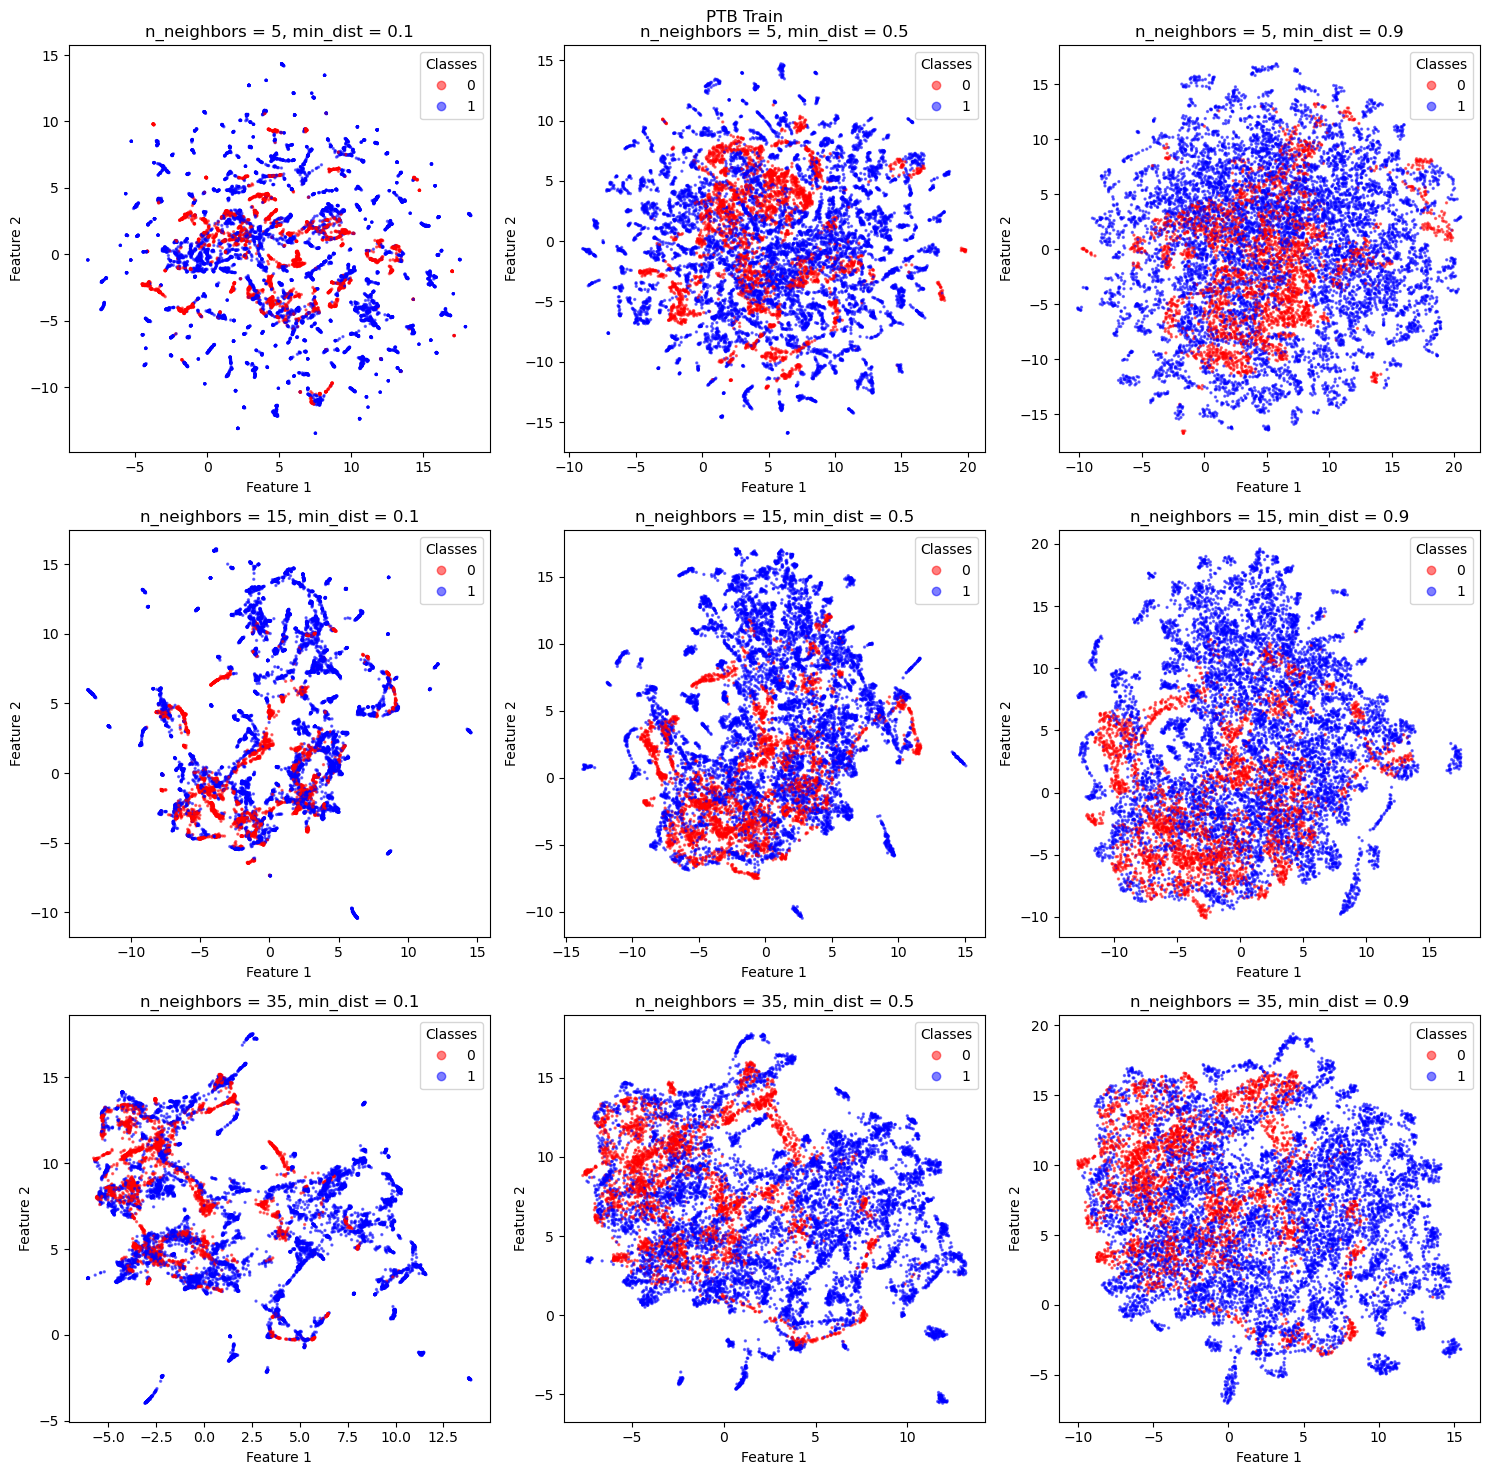

In [24]:
n_neighbors = [5, 15, 35]
min_dist = [.1, .5, .9]
cmap = ListedColormap(['red', 'blue'])

plot_umap_grid(ptb_train_embedding, ptb_train_labels, n_neighbors, min_dist, 'PTB Train', cmap, 2, 0.5)

c:\Users\MarvinLob\anaconda3\envs\ml4h\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\MarvinLob\anaconda3\envs\ml4h\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\MarvinLob\anaconda3\envs\ml4h\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\MarvinLob\anaconda3\envs\ml4h\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. U

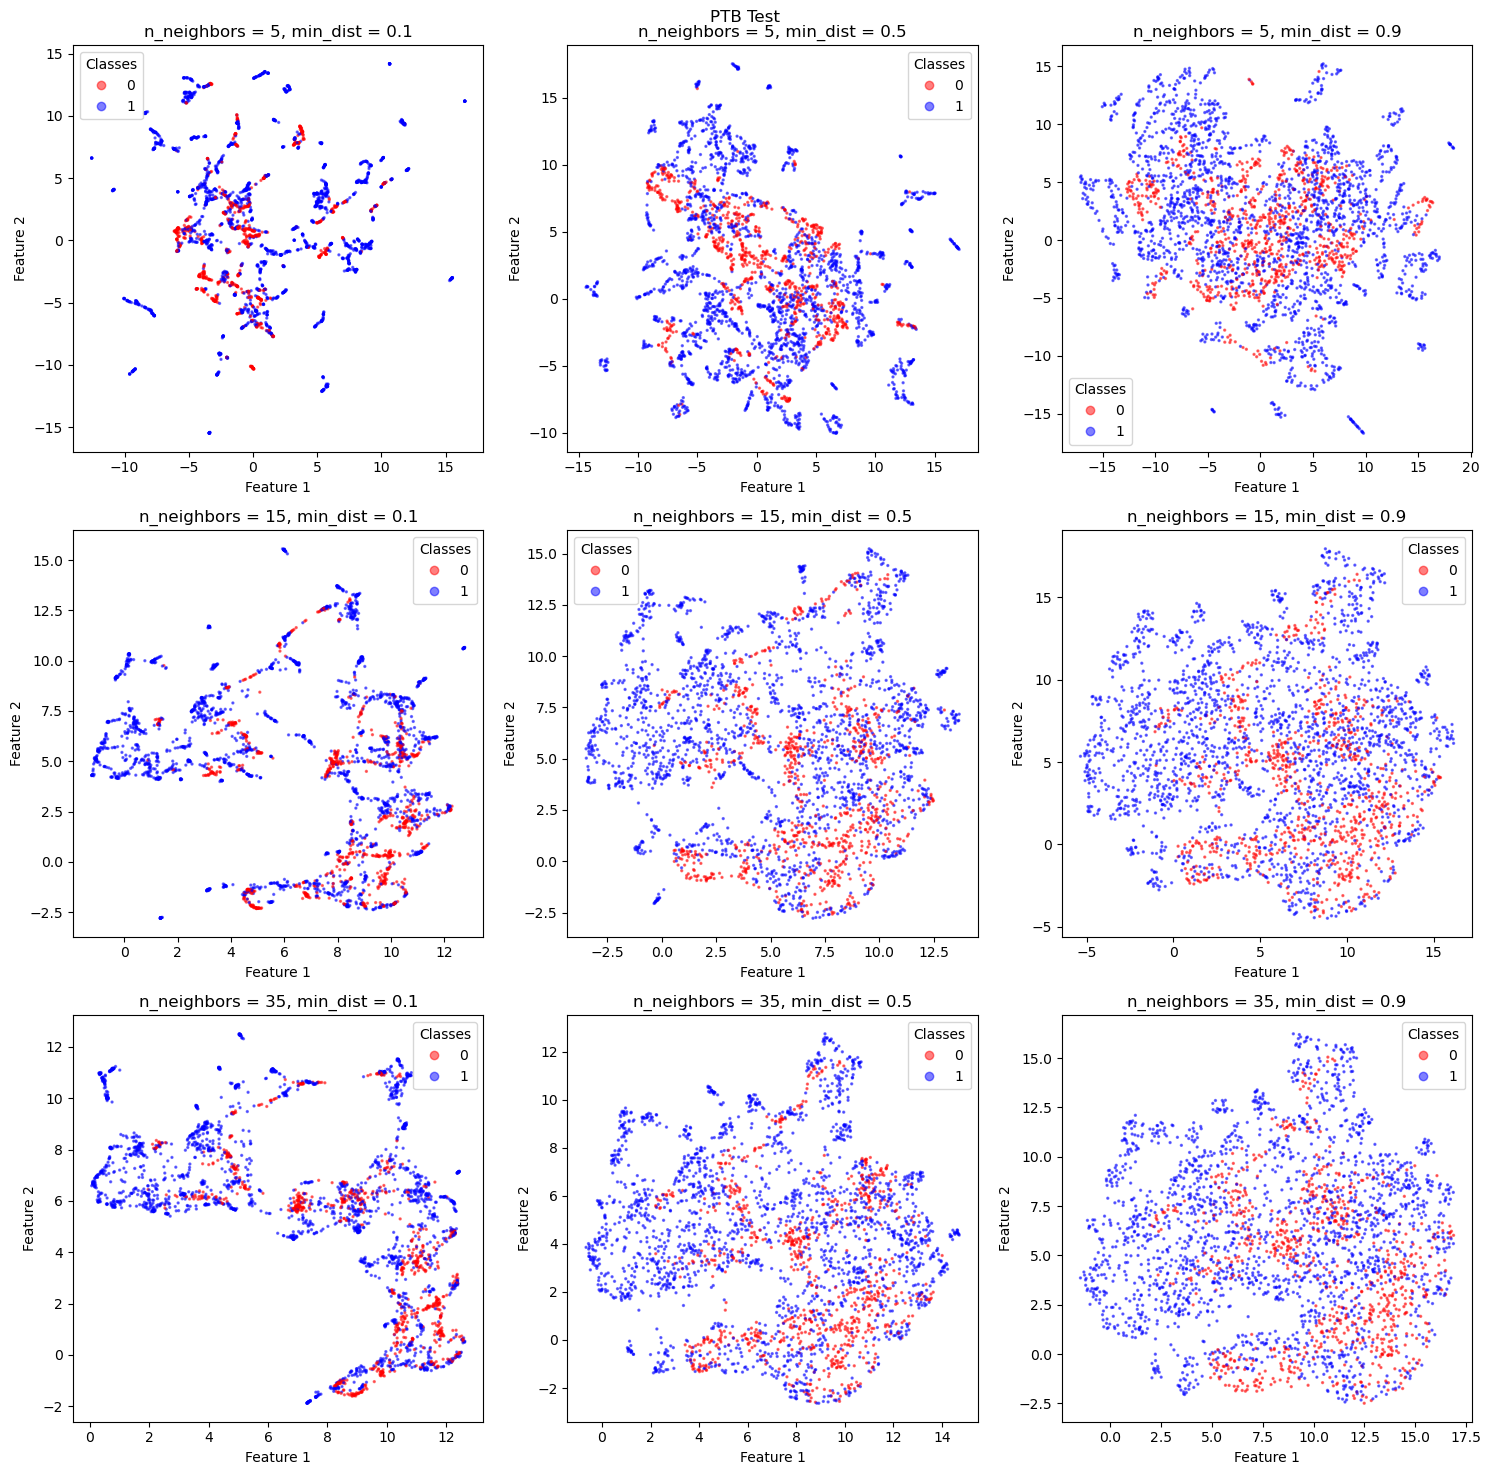

In [25]:
plot_umap_grid(ptb_test_embedding, ptb_test_labels, n_neighbors, min_dist, 'PTB Test', cmap, 2, 0.5)
  

c:\Users\MarvinLob\anaconda3\envs\ml4h\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\MarvinLob\anaconda3\envs\ml4h\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\MarvinLob\anaconda3\envs\ml4h\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\MarvinLob\anaconda3\envs\ml4h\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. U

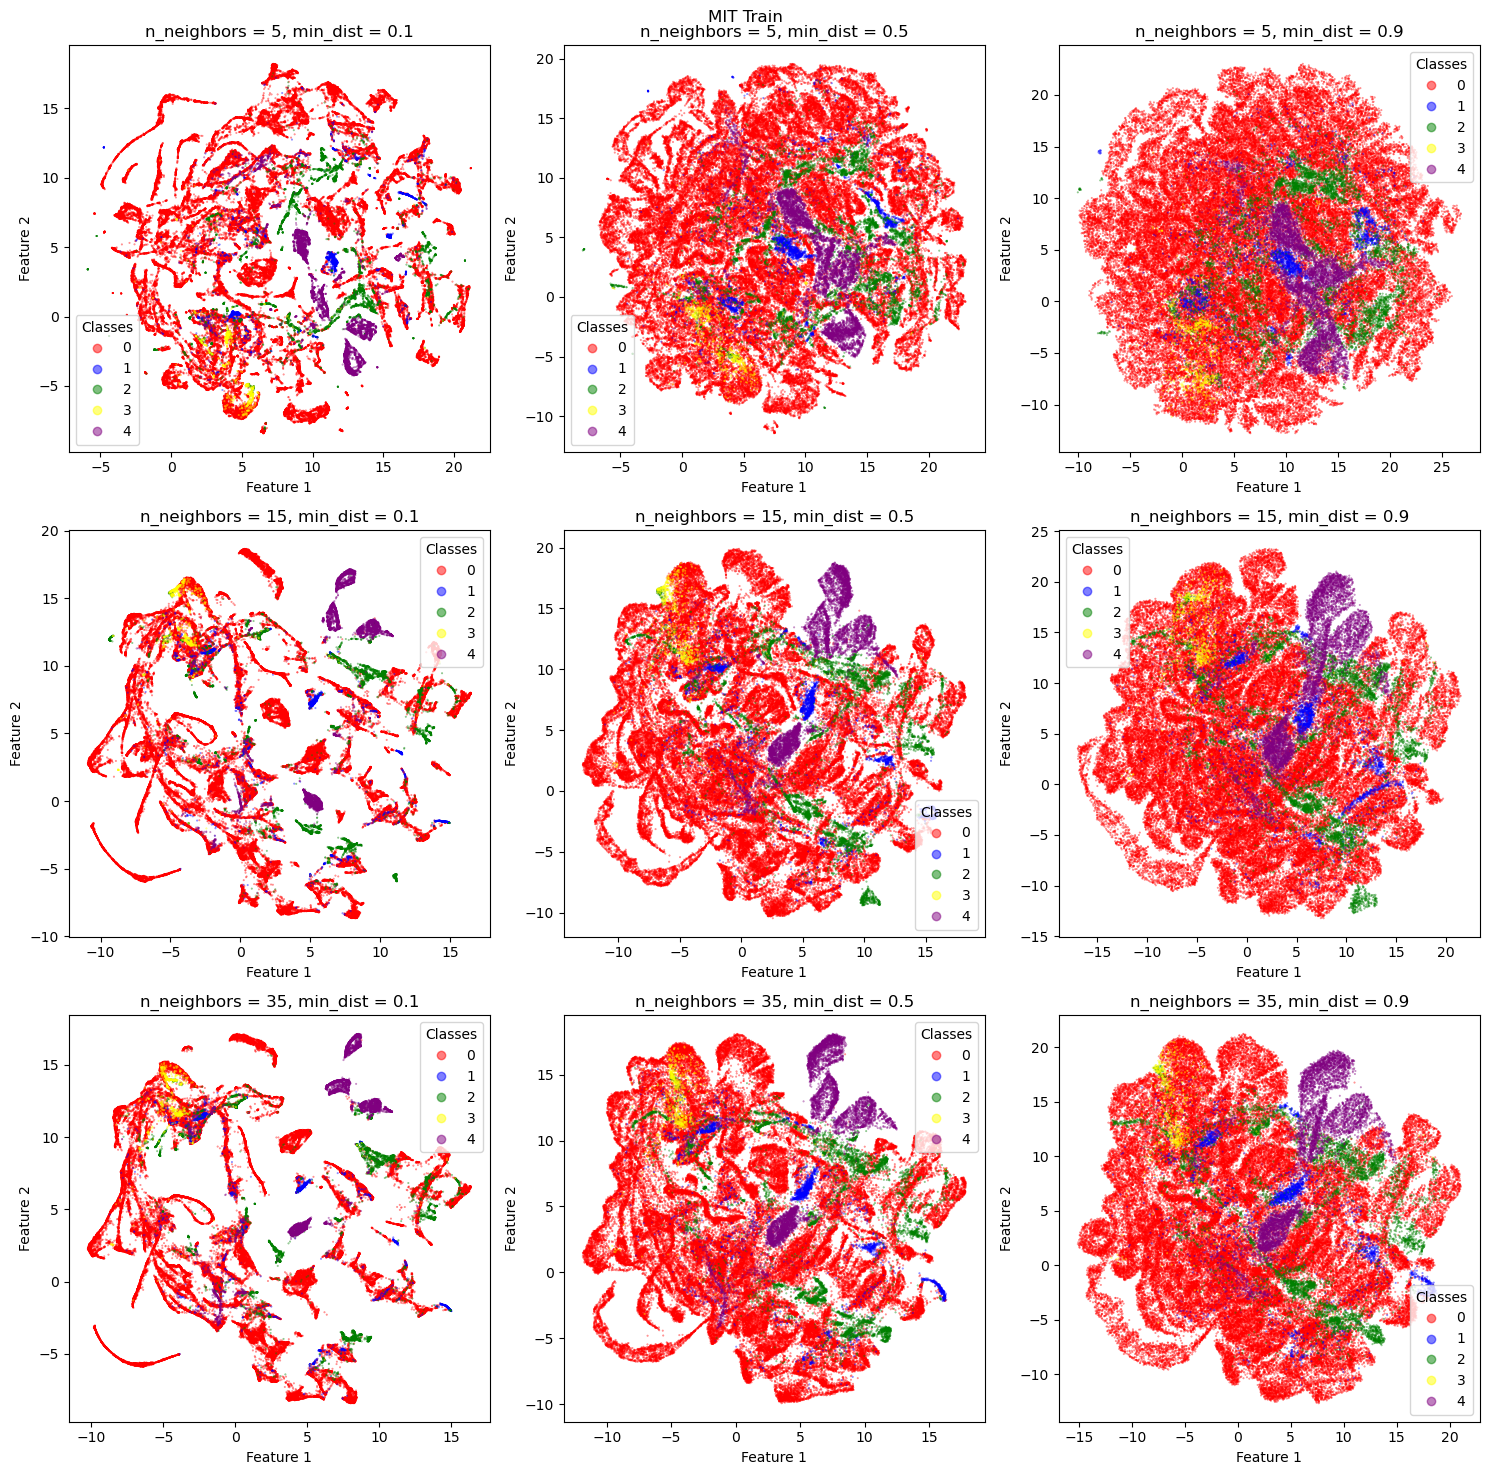

c:\Users\MarvinLob\anaconda3\envs\ml4h\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\MarvinLob\anaconda3\envs\ml4h\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\MarvinLob\anaconda3\envs\ml4h\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\MarvinLob\anaconda3\envs\ml4h\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. U

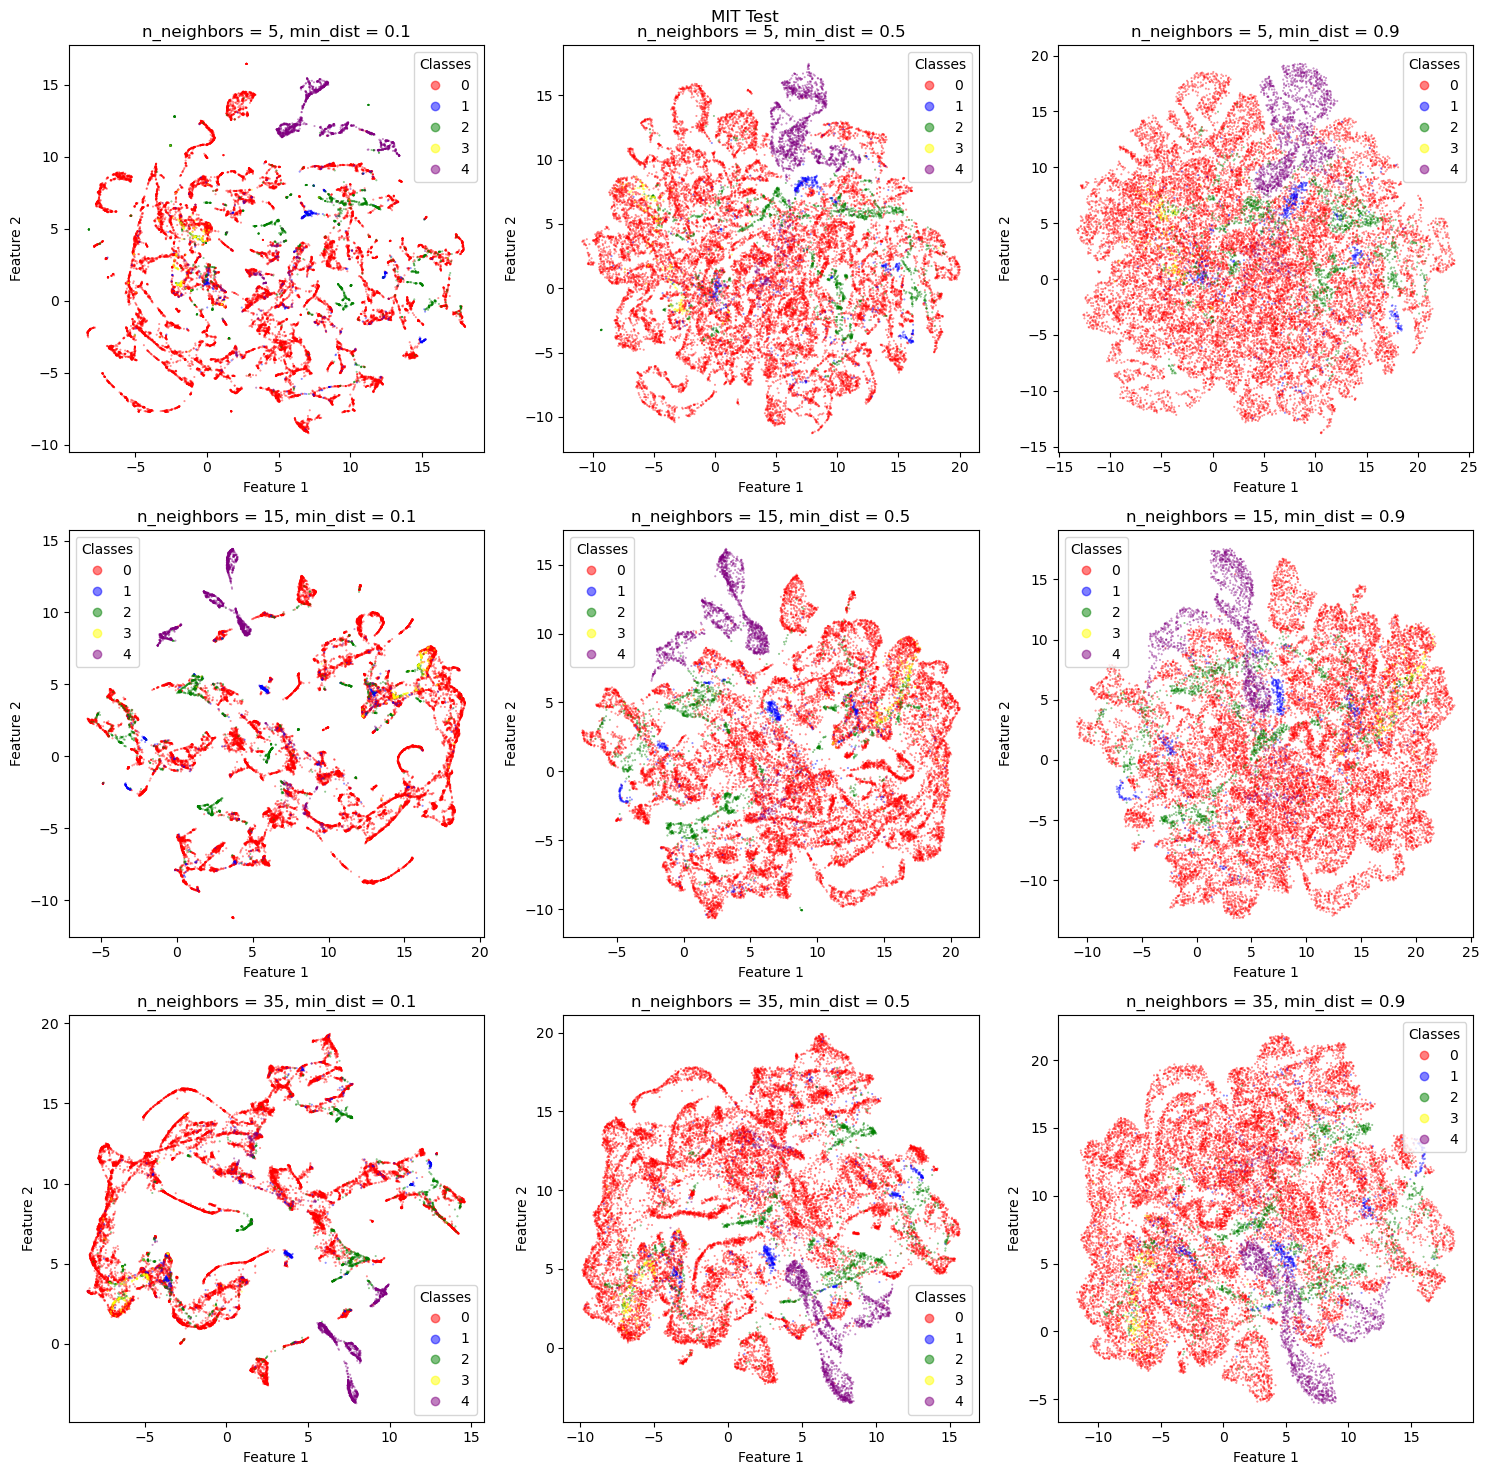

In [27]:
cmap = ListedColormap(['red', 'blue', 'green', 'yellow', 'purple'])

plot_umap_grid(mit_train_embedding, mit_train_labels, n_neighbors, min_dist, 'MIT Train', cmap, .2, 0.5)
plot_umap_grid(mit_test_embedding, mit_test_labels, n_neighbors, min_dist, 'MIT Test', cmap, .2, 0.5)

## Asses if the datasets have the same distribution

In [4]:
def kl_divergence_matrix(embeddings, lables):
    classes = np.unique(lables) 
    kl_matrix = np.zeros((len(classes), len(classes)))
    # diagonal is zero and symmetric
    for i in range(len(classes)):
        for j in range(i+1, len(classes)):
            kl_matrix[i, j] = compute_kl_divergence(embeddings[lables == i], embeddings[lables == j])
            kl_matrix[j, i] = kl_matrix[i, j]
    return kl_matrix


In [12]:
# pick the best hyperparameters for PCA
pca = PCA(n_components=2, random_state=42)
mit_train_reduced = pca.fit_transform(mit_train_embedding)
mit_test_reduced = pca.transform(mit_test_embedding)

In [6]:
matrix_train = kl_divergence_matrix(mit_train_reduced, mit_train_labels)
matrix_test = kl_divergence_matrix(mit_test_reduced, mit_test_labels)


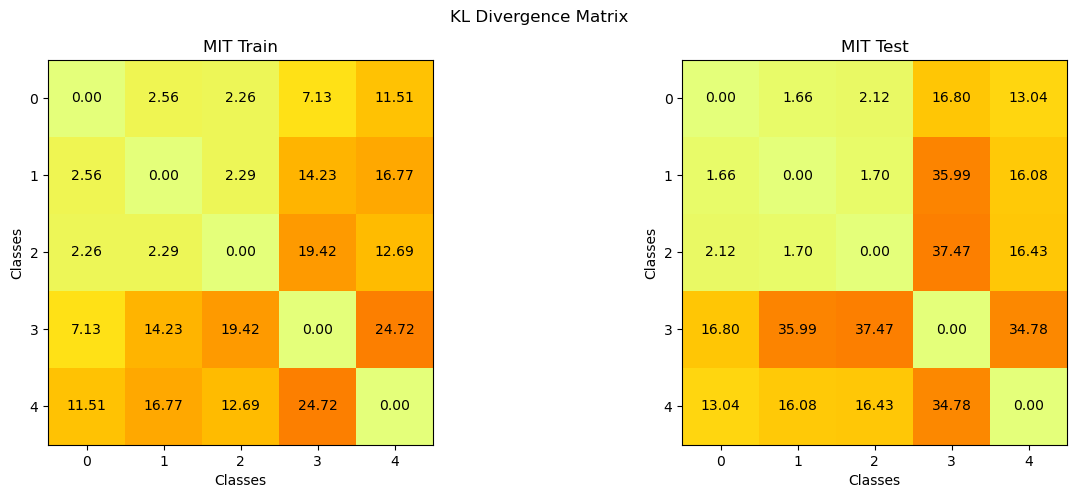

In [7]:
# plot matrix 
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('KL Divergence Matrix')
axs[0].imshow(matrix_train, cmap='Wistia', interpolation='nearest')

# Add the values in the squares
for i in range(matrix_train.shape[0]):
    for j in range(matrix_train.shape[1]):
        axs[0].text(j, i, f'{matrix_train[i, j]:.2f}', ha='center', va='center', color='black')

axs[0].set_title('MIT Train')
axs[0].set_xlabel('Classes')
axs[0].set_ylabel('Classes')
axs[1].imshow(matrix_test, cmap='Wistia', interpolation='nearest')

# Add the values in the squares
for i in range(matrix_test.shape[0]):
    for j in range(matrix_test.shape[1]):
        axs[1].text(j, i, f'{matrix_test[i, j]:.2f}', ha='center', va='center', color='black')

axs[1].set_title('MIT Test')
axs[1].set_xlabel('Classes')
axs[1].set_ylabel('Classes')
plt.show()

In [13]:
# comput ks test for all pairs of classes for mit data
classes = np.unique(mit_train_labels)
ks_matrix_train = np.zeros((len(classes), len(classes)))
ks_matrix_test = np.zeros((len(classes), len(classes)))
for i in range(len(classes)):
    for j in range(i+1, len(classes)):
        ks_matrix_train[i, j] = ndtest.ks2d2s(mit_train_reduced[mit_train_labels == i, 0],
                                              mit_train_reduced[mit_train_labels == i, 1],
                                              mit_train_reduced[mit_train_labels == j, 0],
                                              mit_train_reduced[mit_train_labels == j, 1])
        ks_matrix_train[j, i] = ks_matrix_train[i, j]
        ks_matrix_test[i, j] = ndtest.ks2d2s(mit_test_reduced[mit_test_labels == i, 0],
                                             mit_test_reduced[mit_test_labels == i, 1],
                                             mit_test_reduced[mit_test_labels == j, 0],
                                             mit_test_reduced[mit_test_labels == j, 1])
        ks_matrix_test[j, i] = ks_matrix_test[i, j]
print(ks_matrix_train)

[[0.00000000e+000 5.71880173e-112 0.00000000e+000 4.22411277e-103
  0.00000000e+000]
 [5.71880173e-112 0.00000000e+000 1.15723004e-078 1.70477059e-136
  5.04937692e-186]
 [0.00000000e+000 1.15723004e-078 0.00000000e+000 3.05190051e-164
  1.11746313e-210]
 [4.22411277e-103 1.70477059e-136 3.05190051e-164 0.00000000e+000
  1.63535772e-255]
 [0.00000000e+000 5.04937692e-186 1.11746313e-210 1.63535772e-255
  0.00000000e+000]]


In [4]:
# ptb data
pca = PCA(n_components=2, random_state=42)
ptb_train_reduced = pca.fit_transform(ptb_train_embedding)
ptb_test_reduced = pca.transform(ptb_test_embedding)


In [10]:
# compute ks test for different classes in ptb data
ndtest.ks2d2s(ptb_train_reduced[ptb_train_labels == 0, 0], 
                                        ptb_train_reduced[ptb_train_labels == 0, 1],
                                        ptb_train_reduced[ptb_train_labels == 1, 0],
                                        ptb_train_reduced[ptb_train_labels == 1, 1])


4.816493752234033e-186

In [9]:
train_matrix = kl_divergence_matrix(ptb_train_reduced, ptb_train_labels)
test_matrix = kl_divergence_matrix(ptb_test_reduced, ptb_test_labels)


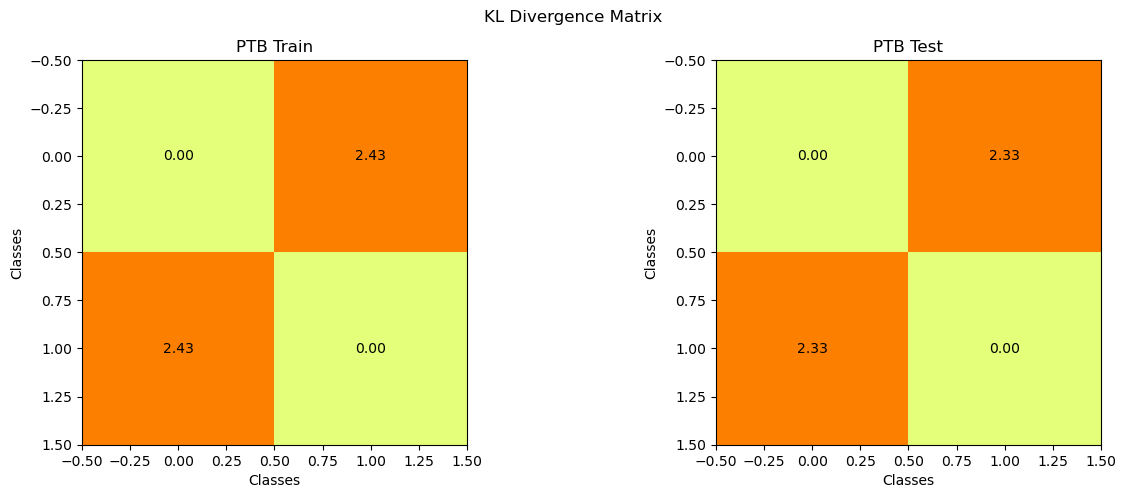

In [10]:
#plot matrix
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('KL Divergence Matrix')
axs[0].imshow(train_matrix, cmap='Wistia', interpolation='nearest')

# Add the values in the squares
for i in range(train_matrix.shape[0]):
    for j in range(train_matrix.shape[1]):
        axs[0].text(j, i, f'{train_matrix[i, j]:.2f}', ha='center', va='center', color='black')

axs[0].set_title('PTB Train')
axs[0].set_xlabel('Classes')
axs[0].set_ylabel('Classes')
axs[1].imshow(test_matrix, cmap='Wistia', interpolation='nearest')

# Add the values in the squares
for i in range(test_matrix.shape[0]):
    for j in range(test_matrix.shape[1]):
        axs[1].text(j, i, f'{test_matrix[i, j]:.2f}', ha='center', va='center', color='black')

axs[1].set_title('PTB Test')
axs[1].set_xlabel('Classes')
axs[1].set_ylabel('Classes')
plt.show()

    

In [11]:
#calculate the Kl divergence between the mit and ptb data all combinations
kl_mit_ptb_train = compute_kl_divergence(mit_train_reduced, ptb_train_reduced)
kl_mit_ptb_test = compute_kl_divergence(mit_test_reduced, ptb_test_reduced)
kl_mit_ptb_train_test = compute_kl_divergence(mit_train_reduced, ptb_test_reduced)
kl_mit_ptb_test_train = compute_kl_divergence(mit_test_reduced, ptb_train_reduced)
kl_mit = compute_kl_divergence(mit_train_reduced, mit_test_reduced)
kl_ptb = compute_kl_divergence(ptb_train_reduced, ptb_test_reduced)

# print results in a table
print('KL Divergence')
print('MIT Train vs PTB Train:', kl_mit_ptb_train)
print('MIT Test vs PTB Test:', kl_mit_ptb_test)
print('MIT Train vs PTB Test:', kl_mit_ptb_train_test)
print('MIT Test vs PTB Train:', kl_mit_ptb_test_train)
print('MIT Train vs MIT Test:', kl_mit)
print('PTB Train vs PTB Test:', kl_ptb)


KL Divergence
MIT Train vs PTB Train: 2.052894193367008
MIT Test vs PTB Test: 1.4132064586039799
MIT Train vs PTB Test: 1.5163510748466889
MIT Test vs PTB Train: 2.024220666471395
MIT Train vs MIT Test: 0.04315689946799192
PTB Train vs PTB Test: 0.1361631980663384


In [12]:
# perform the two-sample test
mit_ptb_train = ndtest.ks2d2s(mit_train_reduced[:,0], mit_train_reduced[:,1], ptb_train_reduced[:,0], ptb_train_reduced[:,1])
mit_ptb_test = ndtest.ks2d2s(mit_test_reduced[:,0], mit_test_reduced[:,1], ptb_test_reduced[:,0], ptb_test_reduced[:,1])
mit_ptb_train_test = ndtest.ks2d2s(mit_train_reduced[:,0], mit_train_reduced[:,1], ptb_test_reduced[:,0], ptb_test_reduced[:,1])
mit_ptb_test_train = ndtest.ks2d2s(mit_test_reduced[:,0], mit_test_reduced[:,1], ptb_train_reduced[:,0], ptb_train_reduced[:,1])
mit = ndtest.ks2d2s(mit_train_reduced[:,0], mit_train_reduced[:,1], mit_test_reduced[:,0], mit_test_reduced[:,1])
ptb = ndtest.ks2d2s(ptb_train_reduced[:,0], ptb_train_reduced[:,1], ptb_test_reduced[:,0], ptb_test_reduced[:,1])

# print results in a table
print('Two-sample test')
print('MIT Train vs PTB Train:', mit_ptb_train)
print('MIT Test vs PTB Test:', mit_ptb_test)
print('MIT Train vs PTB Test:', mit_ptb_train_test)
print('MIT Test vs PTB Train:', mit_ptb_test_train)
print('MIT Train vs MIT Test:', mit)
print('PTB Train vs PTB Test:', ptb)


Two-sample test
MIT Train vs PTB Train: 1.0286822042620597e-160
MIT Test vs PTB Test: 1.5026003853856874e-44
MIT Train vs PTB Test: 5.0455463441408015e-50
MIT Test vs PTB Train: 1.1927080794855546e-118
MIT Train vs MIT Test: 0.49641711933999816
PTB Train vs PTB Test: 0.13345781838169127
